In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Importing Sklearn utils for quick shuffle and accuracy score calculations
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import tensorflow as tf
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train, x_test

# Some required fuctions

In [2]:
img = mpimg.imread('smug_cat.jpg')

def rgb2gray(rgb):
    temp = np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
    temp = temp[..., np.newaxis]
    return temp

def newaxis(a):
    return a[..., np.newaxis]

def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

y_train_hot = one_hot(y_train, 10)
y_test_hot  = one_hot(y_test, 10)
x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]


In [3]:
def relu(x):
    x[x<0]=0
    return x

## Initializations and general overview of architecture

In [4]:

stride_conv = 1
stride_pool = 2
padding = 'True'
ker_dim_c = (5,5)
ker_dim_pool = (2,2)

# Conv1
ker_dim_c1 = (5,5,1)
filt_c1 = 8
ker_volume_c1 = (5,5,filt_c1) #Self terminology for simplicity
out_vol_c1 = (28,28,filt_c1)
ker_val_c1 = np.random.uniform(1e-2,1e-1,ker_volume_c1)
ker_bias_c1 = np.full(out_vol_c1,1e-2)
# Conv2
filt_c2 = 16
ker_dim_c2 = (5,5,filt_c2)
ker_vol_c2 = (5,5,filt_c1,filt_c2)
out_vol_c2 = (14,14,filt_c2)
ker_val_c2 = np.random.uniform(1e-2,1e-1,ker_vol_c2)
ker_bias_c2 = np.full(out_vol_c2,1e-2)
# MLP
input_nodes = 7*7*filt_c2
hidden_nodes = 64

weights_h = np.random.uniform(1e-2,1e-1,(input_nodes,hidden_nodes))
bias_h = np.zeros(hidden_nodes)
# Output
classes = 10
weights_o = np.random.uniform(1e-2,1e-1,(hidden_nodes,classes))
bias_o = np.random.uniform(1e-2,1e-1,classes)

cache_ini = [ker_val_c1, ker_bias_c1, ker_val_c2, ker_bias_c2,
             weights_h, bias_h, weights_o, bias_o]

In [5]:
def conv2D(inp, ker_dim=ker_dim_c, stride=stride_conv,
           padding=padding, ker_val = ker_val_c1, ker_bias = ker_bias_c1):
    
    h,w,d = np.shape(inp)
    ker_list = list(ker_dim)
    ker_list.append(d)
    ker_dim = tuple(ker_list)
    ini_w = 0
    ini_h = 0
    
    pad_w = (((stride-1)*w) + ker_list[1] - stride)/2
    pad_w = int(pad_w)
        
    pad_h = (((stride-1)*h) + ker_list[0] - stride)/2
    pad_h = int(pad_h)
    
    if padding == "True":
        pad_inp = np.zeros(((h+2*pad_h),(w+2*pad_w),d))
        for i in range(d):
            pad_inp[:,:,i] = np.pad(inp[:,:,i], ((pad_h,pad_h),(pad_w,pad_w)), 'constant')
        out_w = int(((w + 2*pad_w - ker_list[1])/stride) + 1)
        out_h = int(((h + 2*pad_h - ker_list[0])/stride) + 1)
    
    else :
        pad_inp = inp
        out_w = int(((w - ker_list[1])/stride) + 1)
        out_h = int(((h - ker_list[0])/stride) + 1)

    conv_out = np.zeros((out_h,out_w))
    for i in range(1,out_h+1):
        for j in range(1,out_w+1):
            temp = pad_inp[ini_h:ini_h + ker_list[0] , ini_w:ini_w + ker_list[1]]
            temp = temp.astype(float)
            ker_val = ker_val.astype(float)
            if temp.shape == ker_val.shape :
                conv_out[i-1][j-1] = np.sum(temp*ker_val)
            ini_w += stride
        ini_h += stride
        ini_w = 0
    
    conv_out += ker_bias
    
#     conv_out = relu(conv_out)
    
    return conv_out,pad_inp

In [6]:
def pool2D(inp, ker_dim=ker_dim_pool, stride=stride_pool):
    h,w = np.shape(inp)
    ker_list = list(ker_dim)
    ker_val = np.ones(ker_dim)

    ini_w = 0
    ini_h = 0
    
    pad_w = (((stride-1)*w) + ker_list[1] - stride)/2
    pad_w = int(pad_w)
        
    pad_h = (((stride-1)*h) + ker_list[0] - stride)/2
    pad_h = int(pad_h)
    
    pad_inp = inp
    out_w = int(((w - ker_list[1])/stride) + 1)
    out_h = int(((h - ker_list[0])/stride) + 1)
    
    pool_out = np.zeros((out_h,out_w))
    mask = np.zeros_like(pad_inp)
    for i in range(1,out_h+1):
        for j in range(1,out_w+1):
            temp = pad_inp[ini_h:ini_h + ker_list[0] , ini_w:ini_w + ker_list[1]]
            temp = temp.astype(float)
            temp1 = mask[ini_h:ini_h + ker_list[0] , ini_w:ini_w + ker_list[1]]
            if temp.shape == ker_val.shape :
                pool_out[i-1][j-1] = np.max(temp)
                lel = temp.flatten()
                lel2 = temp1.flatten()
                lel2[np.argmax(lel)] = 1
            mask[ini_h:ini_h+ker_list[0],ini_w:ini_w+ker_list[1]] = lel2.reshape(temp1.shape)
            ini_w += stride
        ini_h += stride
        ini_w = 0
    
    pool_out = relu(pool_out)
#     print(type(pool_out))
    return pool_out, mask

In [7]:
def Conv2DLayer(inp, ker_dim=ker_dim_c, stride=stride_conv,
           padding=padding, ker_val = ker_val_c1, ker_bias = ker_bias_c1, no_filts=filt_c1) :
    #Bait variable for storing shapes
#     print(ker_val.shape)
    kirby = ker_bias[...,0]
    temp, temp1 = conv2D(inp, ker_dim, ker_bias=kirby)
    no_filts = int(no_filts)
    # Fixing output shape according to number of filters
    out_shape = list(temp.shape)
    out_shape.append(no_filts)
    out_shape = tuple(out_shape)
    # A zeros matrix to store multiple 2d conv outputs
    output = np.zeros(out_shape)
    kernels = []
    for i in range(no_filts):
        ker_val_t = ker_val[...,i]
        ker_val_t = ker_val_t[..., np.newaxis]
        ker_bias_t = ker_bias[...,i]
        output[:,:,i], meh = conv2D(inp, ker_dim, stride, padding, 
                                  ker_val=ker_val_t, ker_bias=ker_bias_t)
    
    pad_inpt = meh
    return output, pad_inpt

In [8]:
def Pool2DLayer(inp, ker_dim, stride) :
    #Bait variable for storing shapes
    shape = list(inp.shape)
    temp,_ = pool2D(inp[:,:,0], ker_dim, stride)
    # Fixing output shape according to number of filters
    out_shape = temp.shape
    out_shape = list(out_shape)
    out_shape.append(shape[2])
    out_shape = tuple(out_shape)
    # A zeros matrix to store multiple 2d conv outputs
    output = np.zeros(out_shape)
    indices = []
    for i in range(shape[2]):
        output[:,:,i] , ind = pool2D(inp[:,:,i], ker_dim, stride)
        indices.append(ind)
#     print(output.shape)
    indices = np.array(indices)
    indices = np.moveaxis(indices, 0, -1)
    return np.array(output), indices

In [9]:
def FClayer(x,W,b):
    return (np.matmul(W.T,x) + b)

def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

def FCNet(inp, no_hidden_layers, output_size, no_hidden_nodes, activations):
    x = inp
    Weights_layers = []
    biases_layers = []
    outputs_layers = []
    k = len(x)
    for i in range(no_hidden_layers):
        l = no_hidden_nodes[i]
        size = (k,l)
        W = np.random.uniform(0,1e-3,size)
        b = np.random.uniform(0,1e-3,l)
        Weights_layers.append(W)
        biases_layers.append(b)
        x = FClayer(x,W,b)
        x = relu(x)
        outputs_layers.append(x)
        k = l
    
    size_new = list(x.shape)
    size_new.append(output_size)
    size_new = tuple(size_new)
    W = np.random.uniform(0,1e-3,size_new)
    b = np.random.uniform(0,1e-3,output_size)
    Weights_layers.append(W)
    biases_layers.append(b)
    x = FClayer(x,W,b)
    outputs_layers.append(x)
    soft_x = softmax(x)
    outputs_layers.append(soft_x)
    
    return Weights_layers, biases_layers, outputs_layers

### Entire model in a flow

In [10]:

def forward_pass(inp, cache_ini):
    [ker_val_c1, ker_bias_c1, ker_val_c2, ker_bias_c2,
             weights_h, bias_h, weights_o, bias_o] = cache_ini
    conv1, pad_inp1 = Conv2DLayer(inp, ker_dim=ker_dim_c, stride=stride_conv,
                    padding=padding, ker_val = ker_val_c1, 
                    ker_bias = ker_bias_c1, no_filts=filt_c1)
    conv1_rel = relu(conv1)
    pool1, ind_1 = Pool2DLayer(conv1_rel, ker_dim=ker_dim_pool, stride=stride_pool)
    conv2, pad_inp2 = Conv2DLayer(pool1, ker_dim=ker_dim_c2, stride=stride_conv,
                   padding=padding, ker_val = ker_val_c2, 
                    ker_bias = ker_bias_c2, no_filts=filt_c2)
    conv2_rel = relu(conv2)
    pool2, ind_2 = Pool2DLayer(conv2_rel, ker_dim=ker_dim_pool, stride=stride_pool)
    flat = pool2.flatten()
    hid = FClayer(flat, weights_h, bias_h)
    hid_rel = hid
    out = FClayer(hid_rel, weights_o, bias_o)
    probs = softmax(out)
    return [conv1, pad_inp1, conv1_rel, pool1, ind_1, conv2, pad_inp2, conv2_rel, pool2, ind_2, flat, hid_rel, out, probs]

In [11]:
def categ_cross_ent(y,y1):
    return -np.sum(y*np.log(y1))

def diff_relu(x):
    x[x>0]=1
    x[x<=0]=0
    return x

In [12]:
# inp = x_train[0]
# gt = y_train[0]
# cache = forward_pass(inp, cache_ini)
# probs = cache[-1]
# loss = categ_cross_ent(gt,probs)
# print(loss)

### Simplified Conv fuction for simpler handling of code

In [13]:
def conv(inp, ker, padding):
    h,w,d = np.shape(inp)
    ker_dim = ker.shape
    ker_list = list(ker_dim)
    ini_w = 0
    ini_h = 0
    
    pad_w = ker_list[1]/2
    pad_w = int(pad_w)
        
    pad_h = ker_list[0]/2
    pad_h = int(pad_h)
    
    if padding == "True":
        pad_inp = np.zeros(((h+2*pad_h),(w+2*pad_w),d))
        for i in range(d):
            pad_inp[:,:,i] = np.pad(inp[:,:,i], ((pad_h,pad_h),(pad_w,pad_w)), 'constant')
        out_w = int(w + 2*pad_w - ker_list[1]+ 1)
        out_h = int(h + 2*pad_h - ker_list[0]+ 1)
    
    else :
        pad_inp = inp
        out_w = int(((w - ker_list[1])/stride) + 1)
        out_h = int(((h - ker_list[0])/stride) + 1)

    conv_out = np.zeros((out_h,out_w))
    ker_val = ker
    for i in range(1,out_h+1):
        for j in range(1,out_w+1):
            temp = pad_inp[ini_h:ini_h + ker_list[0] , ini_w:ini_w + ker_list[1]]
            temp = temp.astype(float)
            ker_val = ker_val.astype(float)
            if temp.shape == ker_val.shape :
                conv_out[i-1][j-1] = np.sum(temp*ker_val)
            ini_w += 1
        ini_h += 1
        ini_w = 0
    
    return conv_out

In [14]:
def conv_backprop(arr,ker):
    pad_inp = arr
    ker_list = list(ker.shape)
    h,w,d = np.shape(arr)
    out_w = int(((w - ker_list[1])) + 1)
    out_h = int(((h - ker_list[0])) + 1)
    out_d = d
    ini_w = 0
    ini_h = 0
    ini_d = 0
    
    ker_val = ker
    
    conv_out = np.zeros((out_h,out_w,out_d))
    for i in range(1,out_h+1):
        for j in range(1,out_w+1):
            for k in range(1, out_d+1):
                temp = pad_inp[ini_h:ini_h + ker_list[0], ini_w:ini_w + ker_list[1], ini_d]
                temp = temp.astype(float)
                ker_val = ker_val.astype(float)
                if temp.shape == ker_val.shape :
                    temp = np.sum(temp*ker_val, axis=0)
                    conv_out[i-1][j-1][k-1] = np.sum(temp*ker_val)
                ini_d += 1
            ini_w += 1
            ini_d = 0
        ini_h += 1
        ini_w = 0
    return conv_out
    
def conv_backprop_volume(arr,kernel):
    depth  = kernel.shape[2]
    temp1  = []
    for i in range(depth):
        temp = conv_backprop(arr,kernel[...,i])
        temp1.append(temp)
    temp1 = np.array(temp1)
    temp1 = np.moveaxis(temp1, 0, -1)
    return temp1

### Stochastic Gradient Descent for Categorical cross entropy mentioned below

In [15]:
def backprop(cache_ini, cache, inp, gt, lr):
    [conv1, pad_inp1, conv1_rel, pool1,
     ind_1, conv2, pad_inp2, conv2_rel, 
     pool2, ind_2, flat, hid_rel, out, probs] = cache
    
    [ker_val_c1, ker_bias_c1, ker_val_c2,
     ker_bias_c2, weights_h, bias_h,
     weights_o, bias_o] = cache_ini
    
    delta = probs - gt
    grad_bias_o = delta
    delta = delta[..., np.newaxis]
    hid_rel = hid_rel[..., np.newaxis]
    grad_weights_o = np.matmul(hid_rel, delta.T)
        
    grad_bias_h = bias_h
    S = np.matmul(weights_o,delta)
    flat = flat[..., np.newaxis]
    grad_weights_h = np.matmul(flat,S.T)
    
    S1 = np.matmul(weights_h, S)
    Sm1 = S1.reshape(pool2.shape)
    
    Sm1_bloat = np.repeat(np.repeat(Sm1,2,axis=0),2,axis=1)
    grad_bloat_2 = Sm1_bloat * ind_2
    grad_bloat_2 = grad_bloat_2 * diff_relu(conv2)
    grad_ker_val_c2 = conv_backprop_volume(pad_inp2,grad_bloat_2)
    ker_bias_c1
    lul = np.swapaxes(ker_val_c2, -1, -2)
    lul = np.rollaxis(lul, -1, 0)
    lul2 = []
    for i in range(len(lul)):
        lul2.append(conv(grad_bloat_2,lul[i], padding="True"))
    lul2 = np.array(lul2)
    Sm2 = np.moveaxis(lul2,0,-1)
    Sm2_bloat = np.repeat(np.repeat(Sm2,2,axis=0),2,axis=1)
    grad_bloat_1 = Sm2_bloat * ind_1
    grad_bloat_1 = grad_bloat_1 * diff_relu(conv1)
    grad_ker_val_c1 = conv_backprop_volume(pad_inp1, grad_bloat_1)
    grad_ker_val_c1 = grad_ker_val_c1.reshape(ker_val_c1.shape)
    
    ker_val_c2 -= lr*grad_ker_val_c2
    ker_val_c1 -= lr*grad_ker_val_c1
    
    ker_bias_c1 -= lr*grad_bloat_1
    ker_bias_c2 -= lr*grad_bloat_2
    
    bias_o    -= lr*grad_bias_o
    weights_o -= lr*grad_weights_o
    
    bias_h    -= lr*grad_bias_h
    weights_h -= lr*grad_weights_h
    
    return cache_ini

### Choosing a very small subset of MNIST because of time constraints

In [16]:
x_train_smol = []
y_train_smol = []

x_test_smol = []
y_test_smol = []
for i in range(10):
    t = np.argwhere(y_train == i)
    x_train_smol.append(x_train[t[:10]])
    y_train_smol.append(y_train[t[:10]])
    x_test_smol.append(x_train[t[200:205]])
    y_test_smol.append(y_train[t[200:205]])

In [17]:
x_train_smol = np.array(x_train_smol)
y_train_smol = np.array(y_train_smol)
x_test_smol  = np.array(x_test_smol)
y_test_smol  = np.array(y_test_smol)

In [18]:
x_train_smol = x_train_smol.reshape(100,28,28,1)
y_train_smol = y_train_smol.reshape(100,1)
y_test_smol  = y_test_smol.reshape(50,1)
x_test_smol  = x_test_smol.reshape(50,28,28,1)

Epoch : 0
1 /100
21 /100
41 /100
61 /100
81 /100
2.3261518461426554


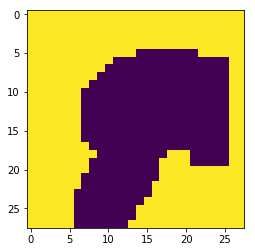

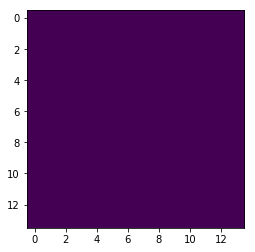

Epoch : 1
1 /100
21 /100
41 /100
61 /100
81 /100
2.312774713957051
Epoch : 2
1 /100
21 /100
41 /100
61 /100
81 /100
2.304605354705677
Epoch : 3
1 /100
21 /100
41 /100
61 /100
81 /100
2.298367956604465
Epoch : 4
1 /100
21 /100
41 /100
61 /100
81 /100
2.2944311332669782
Epoch : 5
1 /100
21 /100
41 /100
61 /100
81 /100
2.2913164695332586
Epoch : 6
1 /100
21 /100
41 /100
61 /100
81 /100
2.2888855246037036
Epoch : 7
1 /100
21 /100
41 /100
61 /100
81 /100
2.2880096294169623
Epoch : 8
1 /100
21 /100
41 /100
61 /100
81 /100
2.2867246787953857
Epoch : 9
1 /100
21 /100
41 /100
61 /100
81 /100
2.2858482363043513
Epoch : 10
1 /100
21 /100
41 /100
61 /100
81 /100
2.2854669020929284


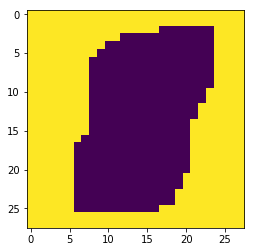

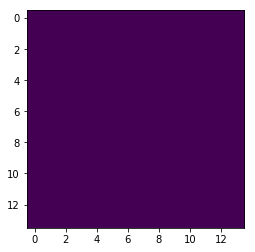

Epoch : 11
1 /100
21 /100
41 /100
61 /100
81 /100
2.285026584833616
Epoch : 12
1 /100
21 /100
41 /100
61 /100
81 /100
2.284713426085995
Epoch : 13
1 /100
21 /100
41 /100
61 /100
81 /100
2.2847535492725046
Epoch : 14
1 /100
21 /100
41 /100
61 /100
81 /100
2.2841893567869302
Epoch : 15
1 /100
21 /100
41 /100
61 /100
81 /100
2.28422809329806
Epoch : 16
1 /100
21 /100
41 /100
61 /100
81 /100
2.284307820212743
Epoch : 17
1 /100
21 /100
41 /100
61 /100
81 /100
2.284196022626705
Epoch : 18
1 /100
21 /100
41 /100
61 /100
81 /100
2.2842411344831346
Epoch : 19
1 /100
21 /100
41 /100
61 /100
81 /100
2.2840858713830077
Epoch : 20
1 /100
21 /100
41 /100
61 /100
81 /100
2.28398534454473


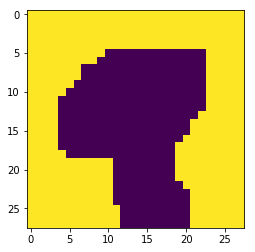

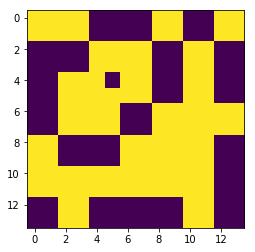

Epoch : 21
1 /100
21 /100
41 /100
61 /100
81 /100
2.284114369306006
Epoch : 22
1 /100
21 /100
41 /100
61 /100
81 /100
2.2838939379796552
Epoch : 23
1 /100
21 /100
41 /100
61 /100
81 /100
2.284032997668476
Epoch : 24
1 /100
21 /100
41 /100
61 /100
81 /100
2.284033566400939
Epoch : 25
1 /100
21 /100
41 /100
61 /100
81 /100
2.2840647546550557
Epoch : 26
1 /100
21 /100
41 /100
61 /100
81 /100
2.283964853541527
Epoch : 27
1 /100
21 /100
41 /100
61 /100
81 /100
2.2838606895438094
Epoch : 28
1 /100
21 /100
41 /100
61 /100
81 /100
2.2840658443184867
Epoch : 29
1 /100
21 /100
41 /100
61 /100
81 /100
2.2840193348257896


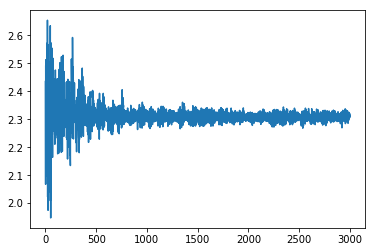

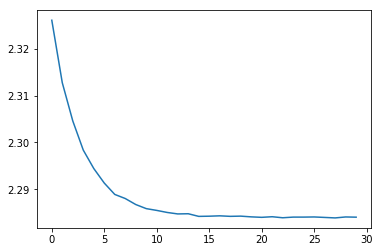

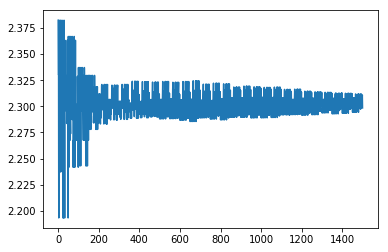

In [19]:
epoch = 30
train_loss = []
train_loss_epoch_avg = []

x_test_smol, y_test_smol = shuffle(x_test_smol, y_test_smol, random_state=0)
y_test_smol_hot = one_hot(y_test_smol, 10)
test_loss = []
for j in range(epoch):
    x_train_smol, y_train_smol = shuffle(x_train_smol, y_train_smol, random_state=0)
    y_train_smol_hot = one_hot(y_train_smol, 10)
    print("Epoch :",j)
    for (inp,gt,count) in zip(x_train_smol,y_train_smol_hot,range(len(y_train_smol))) :
        cache = forward_pass(inp, cache_ini)
        probs = cache[-1]
        loss = categ_cross_ent(gt,probs)
        train_loss.append(loss)
        if count%20 == 1:
            print(count,"/100")
        cache_ini = backprop(cache_ini, cache, inp, gt, 1e-2)

    train_loss_epoch_avg.append(sum(train_loss[-100:-1])/100.0)
    print(sum(train_loss[-100:-1])/100.0)
    
    if j%10 == 0:
        #plottin post relu activation maps for convolutions
        plt.imshow(cache[2][...,0], cmap='gray')
        plt.show()
        plt.imshow(cache[7][...,0], cmap='gray')
        plt.show()
    
    for (inp,gt) in zip(x_test_smol,y_test_smol_hot) :
        cache_test = forward_pass(inp, cache_ini)
        probs = cache_test[-1]
        loss = categ_cross_ent(gt,probs)
        test_loss.append(loss)

plt.plot(train_loss)
plt.show()
plt.plot(train_loss_epoch_avg)
plt.show()
plt.plot(test_loss)
plt.show()

In [ ]:
plt.imshow()

Accuracy calculation takes a lot of headroom, so calculating it after all the epochs. This cell of code can be copy pasted in the above while loop to report accuracies after every epoch

In [20]:
x_test_smol, y_test_smol = shuffle(x_test_smol, y_test_smol, random_state=0)
y_test_smol_hot = one_hot(y_test_smol, 10)
y_pred = []
for (inp,gt) in zip(x_test_smol,y_test_smol_hot) :
    cache = forward_pass(inp, cache_ini)
    probs = cache[-1]
    y_pred.append(probs)
    loss = categ_cross_ent(gt,probs)

In [21]:
y_pred_a = np.array(y_pred)
y_pred_hot = np.zeros_like(y_pred_a)
for i in range(len(y_pred_a)):
    y_pred_hot[:,np.argmax(y_pred[i])] = 1
y_preds = [np.where(r==1)[0][0] for r in y_pred_hot]
y_preds = np.array(y_preds)

In [22]:
accuracy_score(np.squeeze(y_test_smol), y_preds)

0.1

### Batchwise backprop.
Same as previous backprop but slight changes as follows:
1. Forward pass has been moved into this and iteratively samples are forwarded till we get enuf gradients to satisfy batch GD (gradient descent)
2. These gradients have been summed up and updates are made.

In [23]:
def backprop_batch(cache_ini, inp, gt, batch, lr):
    [ker_val_c1, ker_bias_c1, ker_val_c2,
     ker_bias_c2, weights_h, bias_h,
     weights_o, bias_o] = cache_ini
    
    t_grad_ker_val_c1 = 0 
    t_grad_ker_bias_c1 = 0 
    t_grad_ker_val_c2 = 0 
    t_grad_ker_bias_c2 = 0
    
    t_grad_weights_h = 0 
    t_grad_bias_h = 0
    t_grad_weights_o = 0
    t_grad_bias_o = 0
    
    loss = []
    
    for i in range(batch):
        cache = forward_pass(inp[i],cache_ini)
        [conv1, pad_inp1, conv1_rel, pool1,
         ind_1, conv2, pad_inp2, conv2_rel, 
         pool2, ind_2, flat, hid_rel, out, probs] = cache
        loss.append(categ_cross_ent(gt[i],cache[-1]))
        delta = probs - gt[i]
        grad_bias_o = delta
        delta = delta[..., np.newaxis]
        hid_rel = hid_rel[..., np.newaxis]
        grad_weights_o = np.matmul(hid_rel, delta.T)
        t_grad_weights_o += grad_weights_o
        grad_bias_h = np.zeros_like(bias_h)
        t_grad_bias_h += grad_bias_h
        S = np.matmul(weights_o,delta)
        flat = flat[..., np.newaxis]
        grad_weights_h = np.matmul(flat,S.T)
        t_grad_weights_h += grad_weights_h

        S1 = np.matmul(weights_h, S)
        Sm1 = S1.reshape(pool2.shape)

        Sm1_bloat = np.repeat(np.repeat(Sm1,2,axis=0),2,axis=1)
        grad_bloat_2 = Sm1_bloat * ind_2
        grad_bloat_2 = grad_bloat_2 * diff_relu(conv2)
        grad_ker_val_c2 = conv_backprop_volume(pad_inp2,grad_bloat_2)
        
        t_grad_ker_val_c2 += grad_ker_val_c2
        t_grad_ker_bias_c2 += grad_bloat_2
        
        lul = np.swapaxes(ker_val_c2, -1, -2)
        lul = np.rollaxis(lul, -1, 0)
        lul2 = []
        for i in range(len(lul)):
            lul2.append(conv(grad_bloat_2,lul[i], padding="True"))
        lul2 = np.array(lul2)
        Sm2 = np.moveaxis(lul2,0,-1)
        Sm2_bloat = np.repeat(np.repeat(Sm2,2,axis=0),2,axis=1)
        grad_bloat_1 = Sm2_bloat * ind_1
        grad_bloat_1 = grad_bloat_1 * diff_relu(conv1)
        grad_ker_val_c1 = conv_backprop_volume(pad_inp1, grad_bloat_1)
        grad_ker_val_c1 = grad_ker_val_c1.reshape(ker_val_c1.shape)
        
        t_grad_ker_val_c1 += grad_ker_val_c1
        t_grad_ker_bias_c1 += grad_bloat_1
    
    loss_avg = sum(loss)/batch
    
    ker_val_c1 -= lr*t_grad_ker_val_c1
    ker_bias_c1 -= lr*t_grad_ker_bias_c1
    ker_val_c2 -= lr*t_grad_ker_val_c2
    ker_bias_c2 -= lr*t_grad_ker_bias_c2
    weights_h -= lr*t_grad_weights_h
    weights_o -= lr*t_grad_weights_o
    bias_o -= lr*t_grad_bias_o
    
    cache_ini = [ker_val_c1, ker_bias_c1, ker_val_c2,
    ker_bias_c2, weights_h, bias_h,
    weights_o, bias_o]
    
    return cache_ini, cache, loss_avg

Epoch : 0
2.3021825130948894
2.3015952410971856
2.303135404621753
2.303579657769952


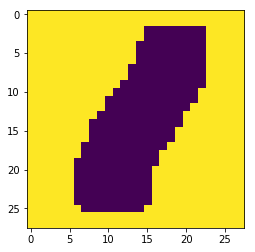

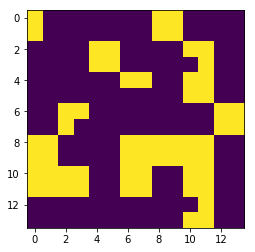

[1.726728289703457]
Epoch : 1
2.3034799546290996
2.3029591006381303
2.301601640287491
2.3024731108224983
[1.726728289703457, 1.7270101738886803]
Epoch : 2
2.3026446143930372
2.3046642315441033
2.30171941197069
2.301624310138393
[1.726728289703457, 1.7270101738886803, 1.7272570644769576]
Epoch : 3
2.302100996041878
2.3012631507802834
2.3032104322617695
2.303963560004148
[1.726728289703457, 1.7270101738886803, 1.7272570644769576, 1.7266436447709828]
Epoch : 4
2.3021002124511973
2.3025977787863208
2.3008989188822544
2.3049211374389476
[1.726728289703457, 1.7270101738886803, 1.7272570644769576, 1.7266436447709828, 1.7263992275299431]
Epoch : 5
2.3035429315341567
2.3042340566820707
2.300396946975862
2.3025290353840258
[1.726728289703457, 1.7270101738886803, 1.7272570644769576, 1.7266436447709828, 1.7263992275299431, 1.7270434837980222]
Epoch : 6
2.3035590582991974
2.3015453208269587
2.3026836183412547
2.3027735560087526
[1.726728289703457, 1.7270101738886803, 1.7272570644769576, 1.726643644

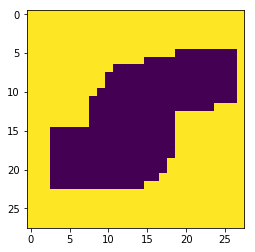

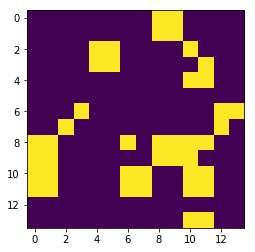

[1.726728289703457, 1.7270101738886803, 1.7272570644769576, 1.7266436447709828, 1.7263992275299431, 1.7270434837980222, 1.7269469993668527, 1.7272672204369774, 1.7269430606360368, 1.72709932672106, 1.7268102858231789]
Epoch : 11
2.301375107796698
2.3020404328804425
2.3028113319572143
2.3042780477191234
[1.726728289703457, 1.7270101738886803, 1.7272570644769576, 1.7266436447709828, 1.7263992275299431, 1.7270434837980222, 1.7269469993668527, 1.7272672204369774, 1.7269430606360368, 1.72709932672106, 1.7268102858231789, 1.7265567181585886]
Epoch : 12
2.3028843368780545
2.3025756411101703
2.301141020918155
2.3039112609407506
[1.726728289703457, 1.7270101738886803, 1.7272570644769576, 1.7266436447709828, 1.7263992275299431, 1.7270434837980222, 1.7269469993668527, 1.7272672204369774, 1.7269430606360368, 1.72709932672106, 1.7268102858231789, 1.7265567181585886, 1.7266502497265952]
Epoch : 13
2.3039755762367538
2.3022576189930843
2.3024418627376737
2.3018551206063744
[1.726728289703457, 1.72701

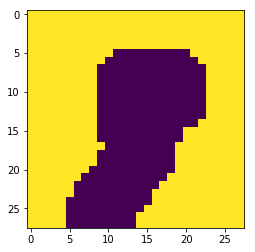

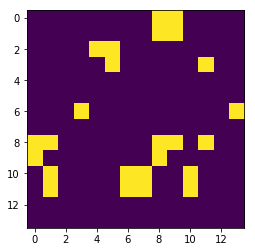

[1.726728289703457, 1.7270101738886803, 1.7272570644769576, 1.7266436447709828, 1.7263992275299431, 1.7270434837980222, 1.7269469993668527, 1.7272672204369774, 1.7269430606360368, 1.72709932672106, 1.7268102858231789, 1.7265567181585886, 1.7266502497265952, 1.727168764491878, 1.726768192263881, 1.7269878541054258, 1.7269436539370713, 1.7268738621195059, 1.7271305676389832, 1.726693230668135, 1.7265997365233878]
Epoch : 21
2.3017230732150136
2.302951468637295
2.3044293238277205
2.3014466034064482
[1.726728289703457, 1.7270101738886803, 1.7272570644769576, 1.7266436447709828, 1.7263992275299431, 1.7270434837980222, 1.7269469993668527, 1.7272672204369774, 1.7269430606360368, 1.72709932672106, 1.7268102858231789, 1.7265567181585886, 1.7266502497265952, 1.727168764491878, 1.726768192263881, 1.7269878541054258, 1.7269436539370713, 1.7268738621195059, 1.7271305676389832, 1.726693230668135, 1.7265997365233878, 1.7272759664200072]
Epoch : 22
2.3030080435659954
2.3021066707104363
2.3015259309983

In [24]:
### Batch training
epoch = 30
batch = 25
train_loss_batch = []
train_loss_epoch_avg = []
test_loss = []

x_test_smol, y_test_smol = shuffle(x_test_smol, y_test_smol, random_state=0)
y_test_smol_hot = one_hot(y_test_smol, 10)

for j in range(epoch):
    x_train_smol, y_train_smol = shuffle(x_train_smol, y_train_smol, random_state=0)
    y_train_smol_hot = one_hot(y_train_smol, 10)
    print("Epoch :",j)
    count = 0
    while(count<len(y_train_smol_hot)):
        (inp,gt) = (x_train_smol[count:count+batch],y_train_smol_hot[count:count+batch])
        cache_init, cache_bat, loss_avg_batch = backprop_batch(cache_ini, inp, gt, batch, 1e-2)
        train_loss_batch.append(loss_avg_batch)
        print(loss_avg_batch)
        count = count+batch
    train_loss_epoch_avg.append(sum(train_loss_batch[-4:-1])/4)
    
    if j%10 == 0:
        #plottin post relu activation maps for convolutions
        plt.imshow(cache_bat[2][...,0], cmap='gray')
        plt.show()
        plt.imshow(cache_bat[7][...,0], cmap='gray')
        plt.show()
    
    for (inp,gt) in zip(x_test_smol,y_test_smol_hot) :
        cache_test = forward_pass(inp, cache_ini)
        probs = cache_test[-1]
        loss = categ_cross_ent(gt,probs)
        test_loss.append(loss)
    print(train_loss_epoch_avg)

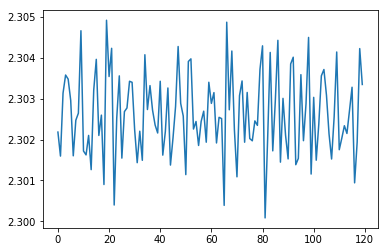

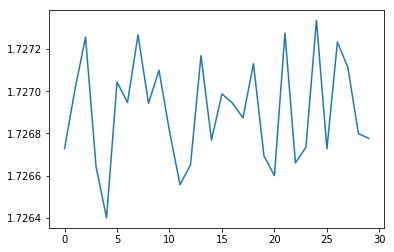

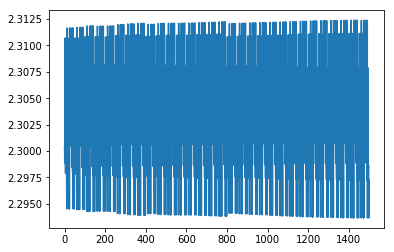

In [25]:
plt.plot(train_loss_batch)
plt.show()
plt.plot(train_loss_epoch_avg)
plt.show()
plt.plot(test_loss)
plt.show()

In [26]:
x_test_smol, y_test_smol = shuffle(x_test_smol, y_test_smol, random_state=0)
y_test_smol_hot = one_hot(y_test_smol, 10)
y_pred = []
for (inp,gt) in zip(x_test_smol,y_test_smol_hot) :
    cache = forward_pass(inp, cache_ini)
    probs = cache[-1]
    y_pred.append(probs)
    loss = categ_cross_ent(gt,probs)

In [27]:
y_pred_a = np.array(y_pred)
y_pred_hot = np.zeros_like(y_pred_a)
for i in range(len(y_pred_a)):
    y_pred_hot[:,np.argmax(y_pred[i])] = 1
y_preds = [np.where(r==1)[0][0] for r in y_pred_hot]
y_preds = np.array(y_preds)

In [28]:
accuracy_score(np.squeeze(y_test_smol), y_preds)

0.1

# Conclusions and Potential issues with this approach

Hard-coding differentiation functions as we did in this assignment can lead to many issues
1. Say one of the expressions is wrong, none of the losses converge

Tensorflow and Keras build a computational graph where all the trainable parameters can be nudged by a small value and hence partial derivative wrt any variable is computed within some margin of error. In hardcoding scenario, it's very difficult to backtrack where the issue is occuring

Also, initialisation plays a huge roll in backprop. Initialising weights as too high can lead to NaN error during backprop

In the following code, kernels seemed to be learning some maps but the loss and results say otherwise. Have tested this code with multiple initialisations, learning rates, shuffle seeds, no shuffles, batch GD, SGD but nothing worked and accuracy never crossed 0.1